# Аспектный анализ тональности текстов

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## Оригинальная разметка

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'

In [3]:
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [4]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [5]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [6]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

In [ ]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

####  Аспекты (aspects)

In [ ]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

## BIO-тэги для обучения модели

In [7]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [ ]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

### Разбиение текста на предложения, а предложений - на слова.

In [8]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [9]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [ ]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

##  Подготовка данных для обучения: 

In [10]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [11]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

### Токенизация: 

In [12]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [13]:
len(training_data), len(test_data)

(2210, 1922)

In [14]:
all_data = training_data + test_data

In [15]:
vocabulary,labels = form_vocabulary_and_tagset(all_data)

In [16]:
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [17]:
len(vocabulary), len(labels)

(11333, 15)

#### индексация:

In [18]:
from dlnlputils.sentiment_utils import Converter, generate_markup

In [19]:
converter = Converter(vocabulary,labels)

In [20]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [21]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [ ]:
# !pip3 install wget

In [22]:
import zipfile
import gensim

In [ ]:
import wget

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
wget.download(model_url)
# def download_file(url, file_name, folder):
#     import os
#     from os.path import join
#     from os import makedirs
#     from urllib.request import urlretrieve

#     if not os.path.exists(folder):
#         makedirs(folder)

#     urlretrieve(url, join(folder, file_name))

# download_file(model_url, 'model.zip', '.')
model_file = 'datasets/' + model_url.split('/')[-1]

In [23]:
gensim.__version__

'3.8.1'

In [24]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

жигулёнка 0.7488205432891846
ишачка 0.7310285568237305
грузовичка 0.7278668880462646
жигулёнок 0.7127147912979126
жигуленок 0.706432044506073
тележка 0.6995413899421692
мопед 0.6990943551063538
сачка 0.6923120021820068
катафалка 0.6904969811439514
бричка 0.6855131387710571


двигатели 0.9118232727050781
гипердвигатель 0.8655393123626709
электродвигатель 0.8446589708328247
мотор 0.8106047511100769
электромотор 0.8067886233329773
авиадвигатель 0.7910490036010742
движок 0.7793391346931458
перводвигатель 0.7768319249153137
двигательный 0.7394744157791138
турбина 0.7326768636703491


bmw 0.7961359620094299
бмв 0.7914925813674927
аудь 0.7911134958267212
тойота 0.7723557353019714
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522681951522827
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473038673401




In [25]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная

In [26]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

In [27]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [28]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


In [29]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training

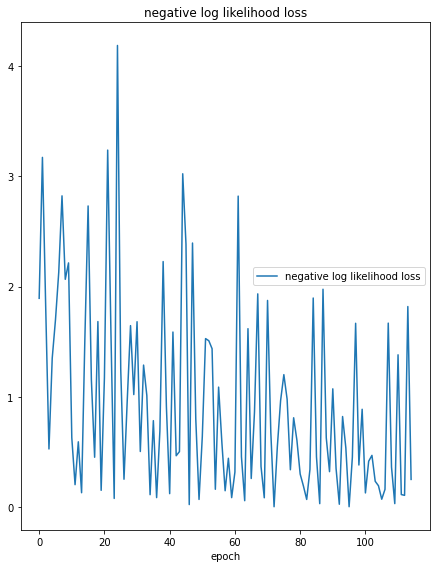

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.003, max:    4.185, cur:    0.251)


In [31]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        tag_scores     = model(encoded_recipe)
        
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss.detach()})
            liveplot.draw()
            

In [32]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [33]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [34]:
from dlnlputils.sentiment_utils import tag_statistics

In [35]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 15813
      всего:	 19922
% корректно:	 79.37456078706957

для B-Whole:
  корректно:	 503
      всего:	 673
% корректно:	 74.73997028231798

для B-Driveability:
  корректно:	 404
      всего:	 1066
% корректно:	 37.89868667917448

для I-Driveability:
  корректно:	 298
      всего:	 711
% корректно:	 41.91279887482419

для B-Appearance:
  корректно:	 151
      всего:	 275
% корректно:	 54.90909090909091

для I-Appearance:
  корректно:	 40
      всего:	 100
% корректно:	 40.0

для B-Reliability:
  корректно:	 339
      всего:	 809
% корректно:	 41.90358467243511

для I-Whole:
  корректно:	 107
      всего:	 213
% корректно:	 50.23474178403756

для B-Comfort:
  корректно:	 633
      всего:	 1067
% корректно:	 59.32521087160263

для I-Comfort:
  корректно:	 194
      всего:	 497
% корректно:	 39.03420523138833

для I-Reliability:
  корректно:	 145
      всего:	 475
% корректно:	 30.526315789473685

для B-Costs:
  корректно:	 2

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

In [36]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [37]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

c:\Users\Михаил\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Other', 'B-Whole', 'B-Driveability', 'I-Driveability', 'B-Appearance', 'I-Appearance', 'B-Reliability', 'I-Whole', 'B-Comfort', 'I-Comfort', 'I-Reliability', 'B-Costs', 'I-Costs', 'B-Safety', 'I-Safety'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


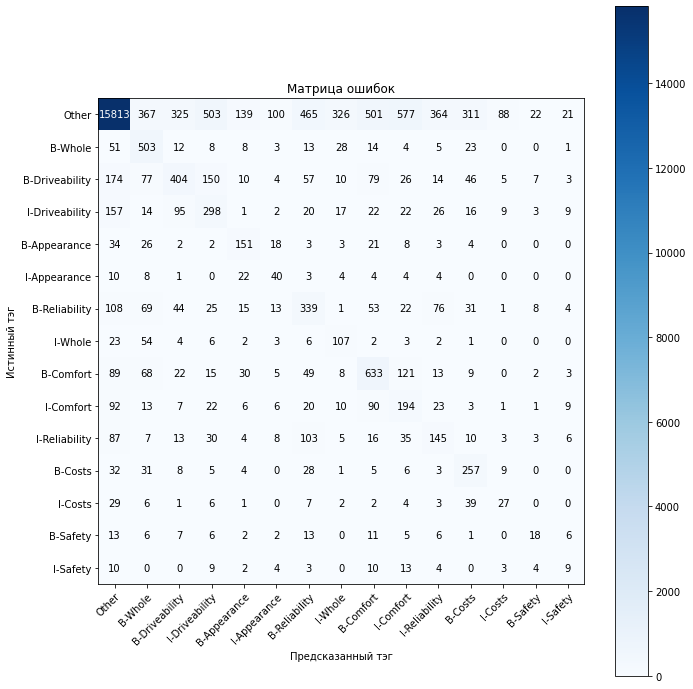

In [38]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

c:\Users\Михаил\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Other', 'B-Whole', 'B-Driveability', 'I-Driveability', 'B-Appearance', 'I-Appearance', 'B-Reliability', 'I-Whole', 'B-Comfort', 'I-Comfort', 'I-Reliability', 'B-Costs', 'I-Costs', 'B-Safety', 'I-Safety'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


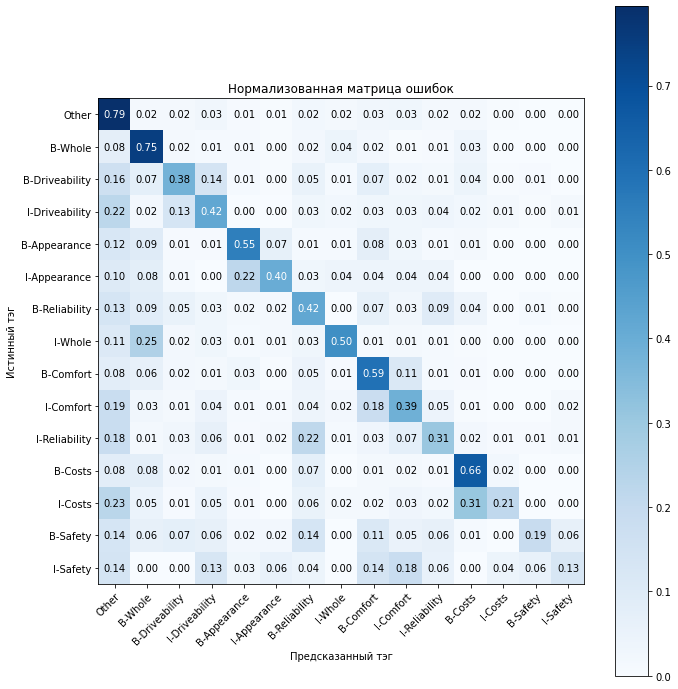

In [39]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()